In [1]:
import re
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
sns.set(font_scale = 1.5)

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [2]:
from geographiclib.geodesic import Geodesic
from astropy.stats import circcorrcoef
from astropy import units as u

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
original_data = pd.read_csv('../data-sources/forecasting-floats/atlantic-data.csv')
original_data.head()

,significantWaveHeight [m],peakPeriod [s],meanPeriod [s],peakDirection [degrees],peakDirectionalSpread [degrees],meanDirection [degrees],meanDirectionalSpread [degrees],timestamp [utc],latitude [decimal degrees],longitude [decimal degrees],epoch [s],spotId
0,1.576,6.827,5.231,268.062,26.141,245.366,52.564,2021-05-30 00:16:49+00:00,34.95782,290.06765,1622333809,0
1,1.544,6.827,5.159,264.063,30.325,242.607,53.059,2021-05-30 01:16:49+00:00,34.96202,290.06473,1622337409,0
2,1.590,7.314,5.288,267.427,31.451,243.648,51.565,2021-05-30 02:16:49+00:00,34.96605,290.06040,1622341009,0
3,1.617,7.314,5.229,263.254,34.004,236.917,53.388,2021-05-30 03:16:49+00:00,34.97025,290.05493,1622344609,0
4,1.547,7.314,5.278,265.768,31.605,239.341,52.841,2021-05-30 04:16:49+00:00,34.97540,290.04875,1622348209,0


In [4]:
original_data.columns = [column.split(' ')[0] for column in original_data.columns]
column_names_compiler = re.compile(r'(?<=[a-z])(?=[A-Z])')
new_column_names = [column_names_compiler.sub(' ', column) for column in original_data.columns]
new_column_names = [column.title() for column in new_column_names]
original_data.columns = new_column_names

In [5]:
original_data.drop(columns=['Epoch'], inplace=True)
original_data = original_data[['Spot Id', 'Timestamp'] +
                              [column for column in original_data.columns if column not in ['Spot Id', 'Timestamp']]]

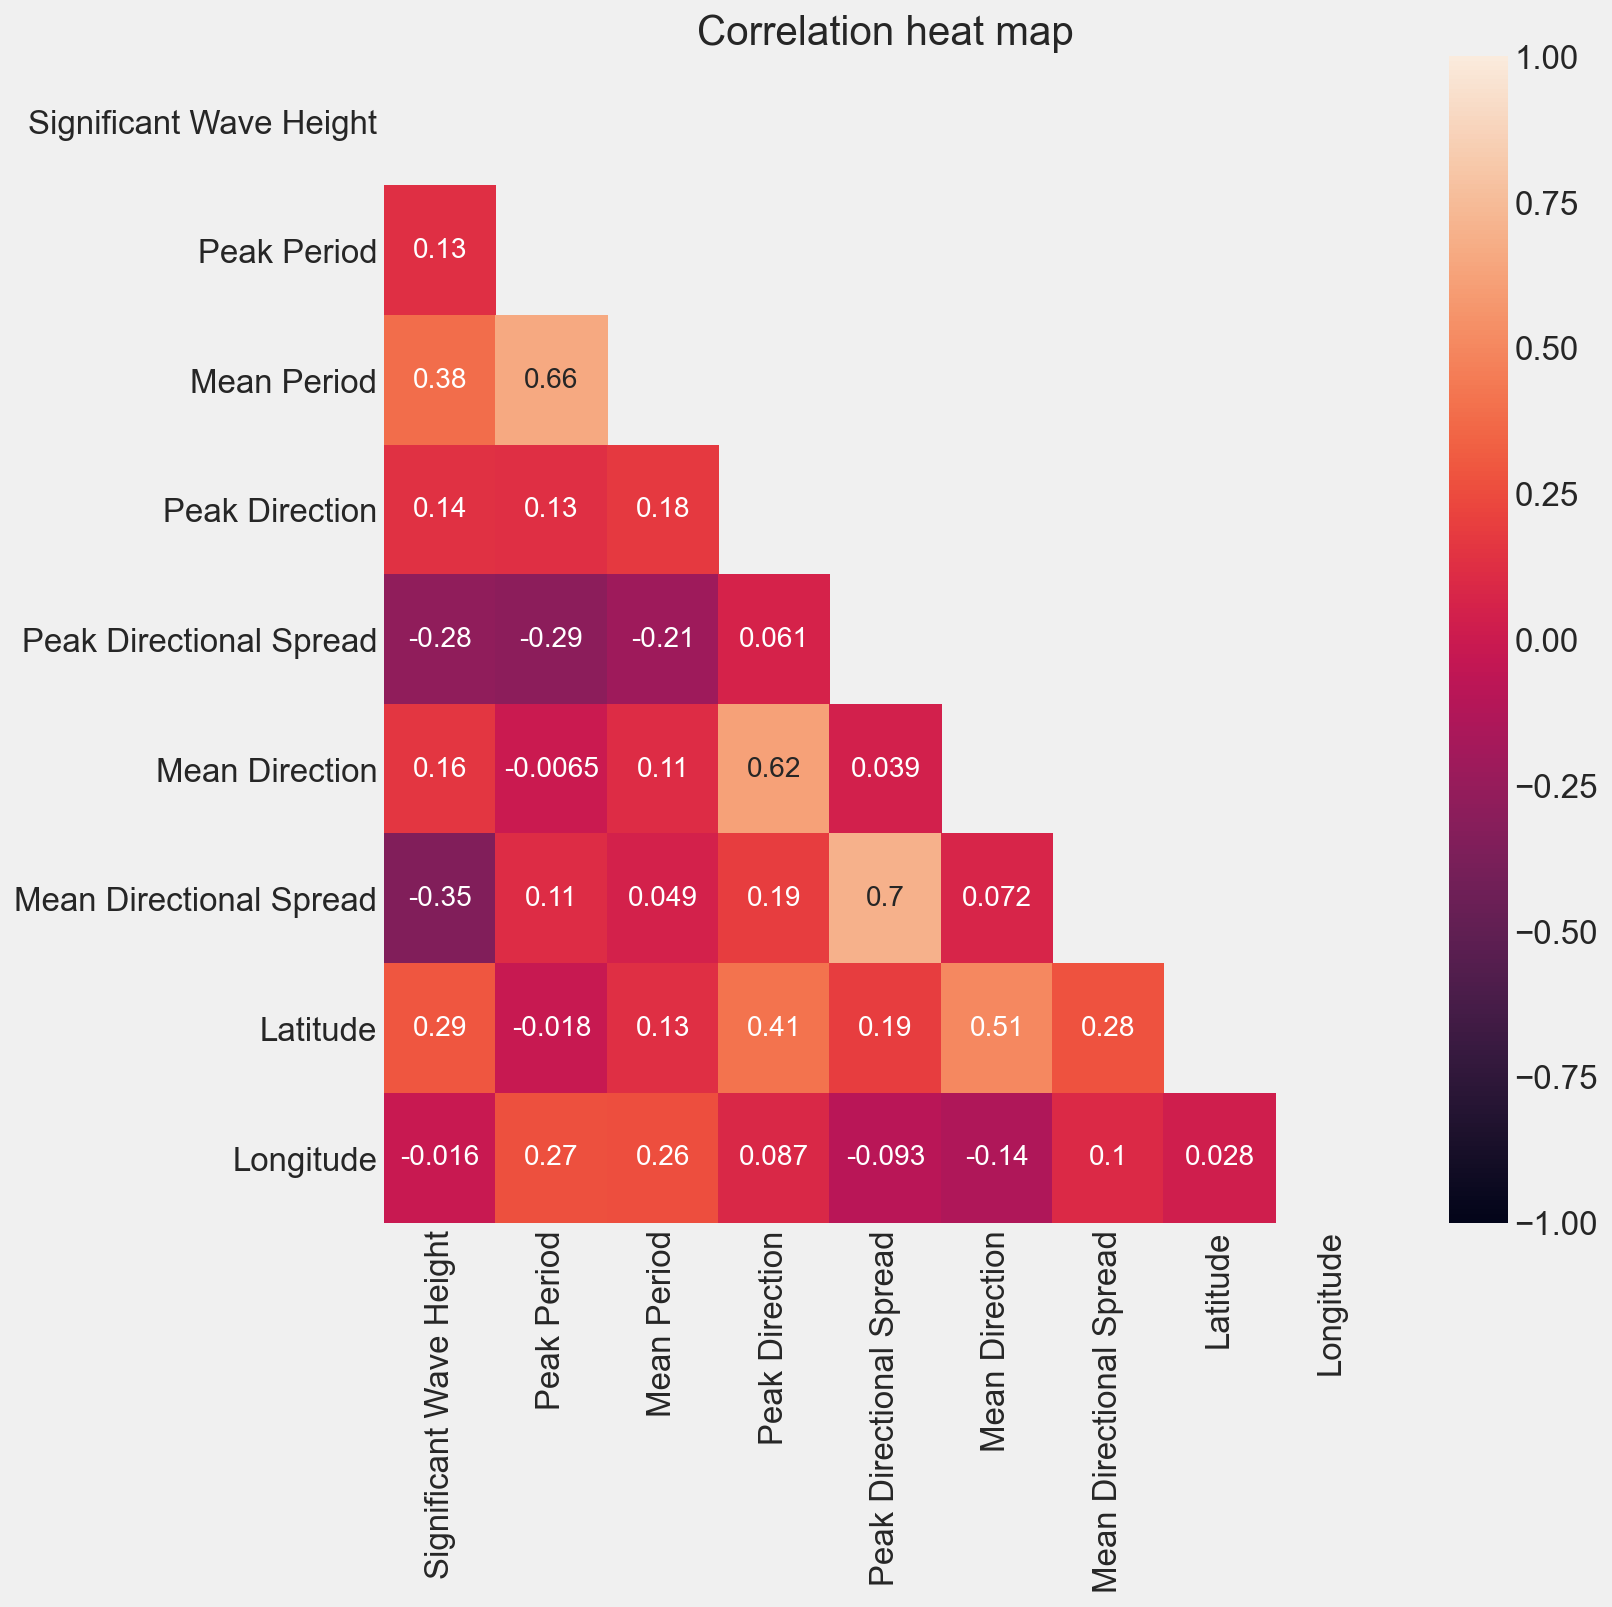

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
mask = np.zeros_like(original_data[original_data.columns[1:]].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(original_data[original_data.columns[1:]].corr(), mask=mask, annot=True, vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation heat map')
plt.show()

In [7]:
original_data.head()

,Spot Id,Timestamp,Significant Wave Height,Peak Period,Mean Period,Peak Direction,Peak Directional Spread,Mean Direction,Mean Directional Spread,Latitude,Longitude
0,0,2021-05-30 00:16:49+00:00,1.576,6.827,5.231,268.062,26.141,245.366,52.564,34.95782,290.06765
1,0,2021-05-30 01:16:49+00:00,1.544,6.827,5.159,264.063,30.325,242.607,53.059,34.96202,290.06473
2,0,2021-05-30 02:16:49+00:00,1.590,7.314,5.288,267.427,31.451,243.648,51.565,34.96605,290.06040
3,0,2021-05-30 03:16:49+00:00,1.617,7.314,5.229,263.254,34.004,236.917,53.388,34.97025,290.05493
4,0,2021-05-30 04:16:49+00:00,1.547,7.314,5.278,265.768,31.605,239.341,52.841,34.97540,290.04875


In [8]:
def heading(cell):
    heading = round(Geodesic.WGS84.Inverse(cell[9], cell[10], cell[11], cell[12])['azi1'], 2)
    if heading < 0:
        return heading + 360
    else:
        return heading

def distance(cell):
    return round(Geodesic.WGS84.Inverse(cell[9], cell[10], cell[11], cell[12])['s12'], 2)

In [9]:
first_buoy_data = original_data[original_data['Spot Id'] == 0]
first_buoy_data['Next_Latitude'] = first_buoy_data['Latitude'].shift(-1)
first_buoy_data['Next_Longitude'] = first_buoy_data['Longitude'].shift(-1)

first_buoy_data['Heading'] = first_buoy_data.apply(heading, axis=1)
first_buoy_data['Distance'] = first_buoy_data.apply(distance, axis=1).shift(1)

In [10]:
for buoy in original_data['Spot Id'].unique()[1:]:
    subs_buoy_data = original_data[original_data['Spot Id'] == buoy]
    subs_buoy_data['Next_Latitude'] = subs_buoy_data['Latitude'].shift(-1)
    subs_buoy_data['Next_Longitude'] = subs_buoy_data['Longitude'].shift(-1)
    subs_buoy_data['Heading'] = subs_buoy_data.apply(heading, axis=1)
    subs_buoy_data['Distance'] = subs_buoy_data.apply(distance, axis=1).shift(1)
    first_buoy_data = pd.concat([first_buoy_data, subs_buoy_data], ignore_index=True)

In [11]:
first_buoy_data.drop(['Next_Latitude', 'Next_Longitude'], axis=1, inplace=True)

In [12]:
first_buoy_data.to_csv('../data-sources/forecasting-floats/cleaned-buoy-data.csv', index=False)

In [13]:
buoy_data = pd.read_csv('../data-sources/forecasting-floats/cleaned-buoy-data.csv')

In [14]:
buoy_data.head()

,Spot Id,Timestamp,Significant Wave Height,Peak Period,Mean Period,Peak Direction,Peak Directional Spread,Mean Direction,Mean Directional Spread,Latitude,Longitude,Heading,Distance
0,0,2021-05-30 00:16:49+00:00,1.576,6.827,5.231,268.062,26.141,245.366,52.564,34.95782,290.06765,330.22,NaN
1,0,2021-05-30 01:16:49+00:00,1.544,6.827,5.159,264.063,30.325,242.607,53.059,34.96202,290.06473,318.51,536.87
2,0,2021-05-30 02:16:49+00:00,1.590,7.314,5.288,267.427,31.451,243.648,51.565,34.96605,290.06040,313.01,596.88
3,0,2021-05-30 03:16:49+00:00,1.617,7.314,5.229,263.254,34.004,236.917,53.388,34.97025,290.05493,315.35,683.12
4,0,2021-05-30 04:16:49+00:00,1.547,7.314,5.278,265.768,31.605,239.341,52.841,34.97540,290.04875,311.99,803.07


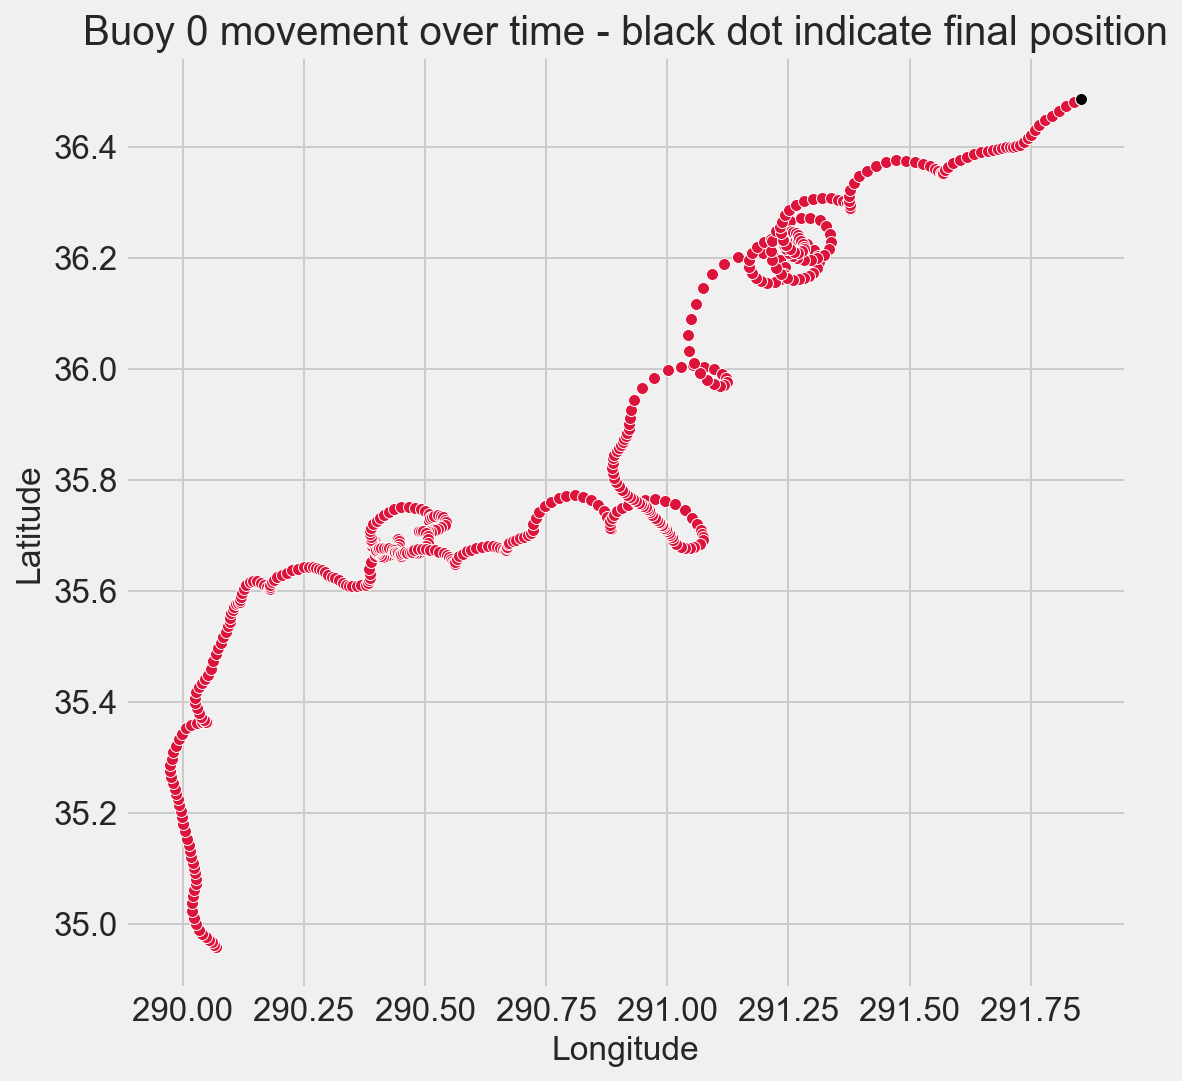

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=buoy_data[buoy_data['Spot Id'] == 0], x='Longitude', y='Latitude', c=['crimson'])
sns.scatterplot(data=buoy_data[buoy_data['Spot Id'] == 0][-1:], x='Longitude', y='Latitude', c=['black'])
ax.set_title('Buoy 0 movement over time - black dot indicate final position')
plt.show()

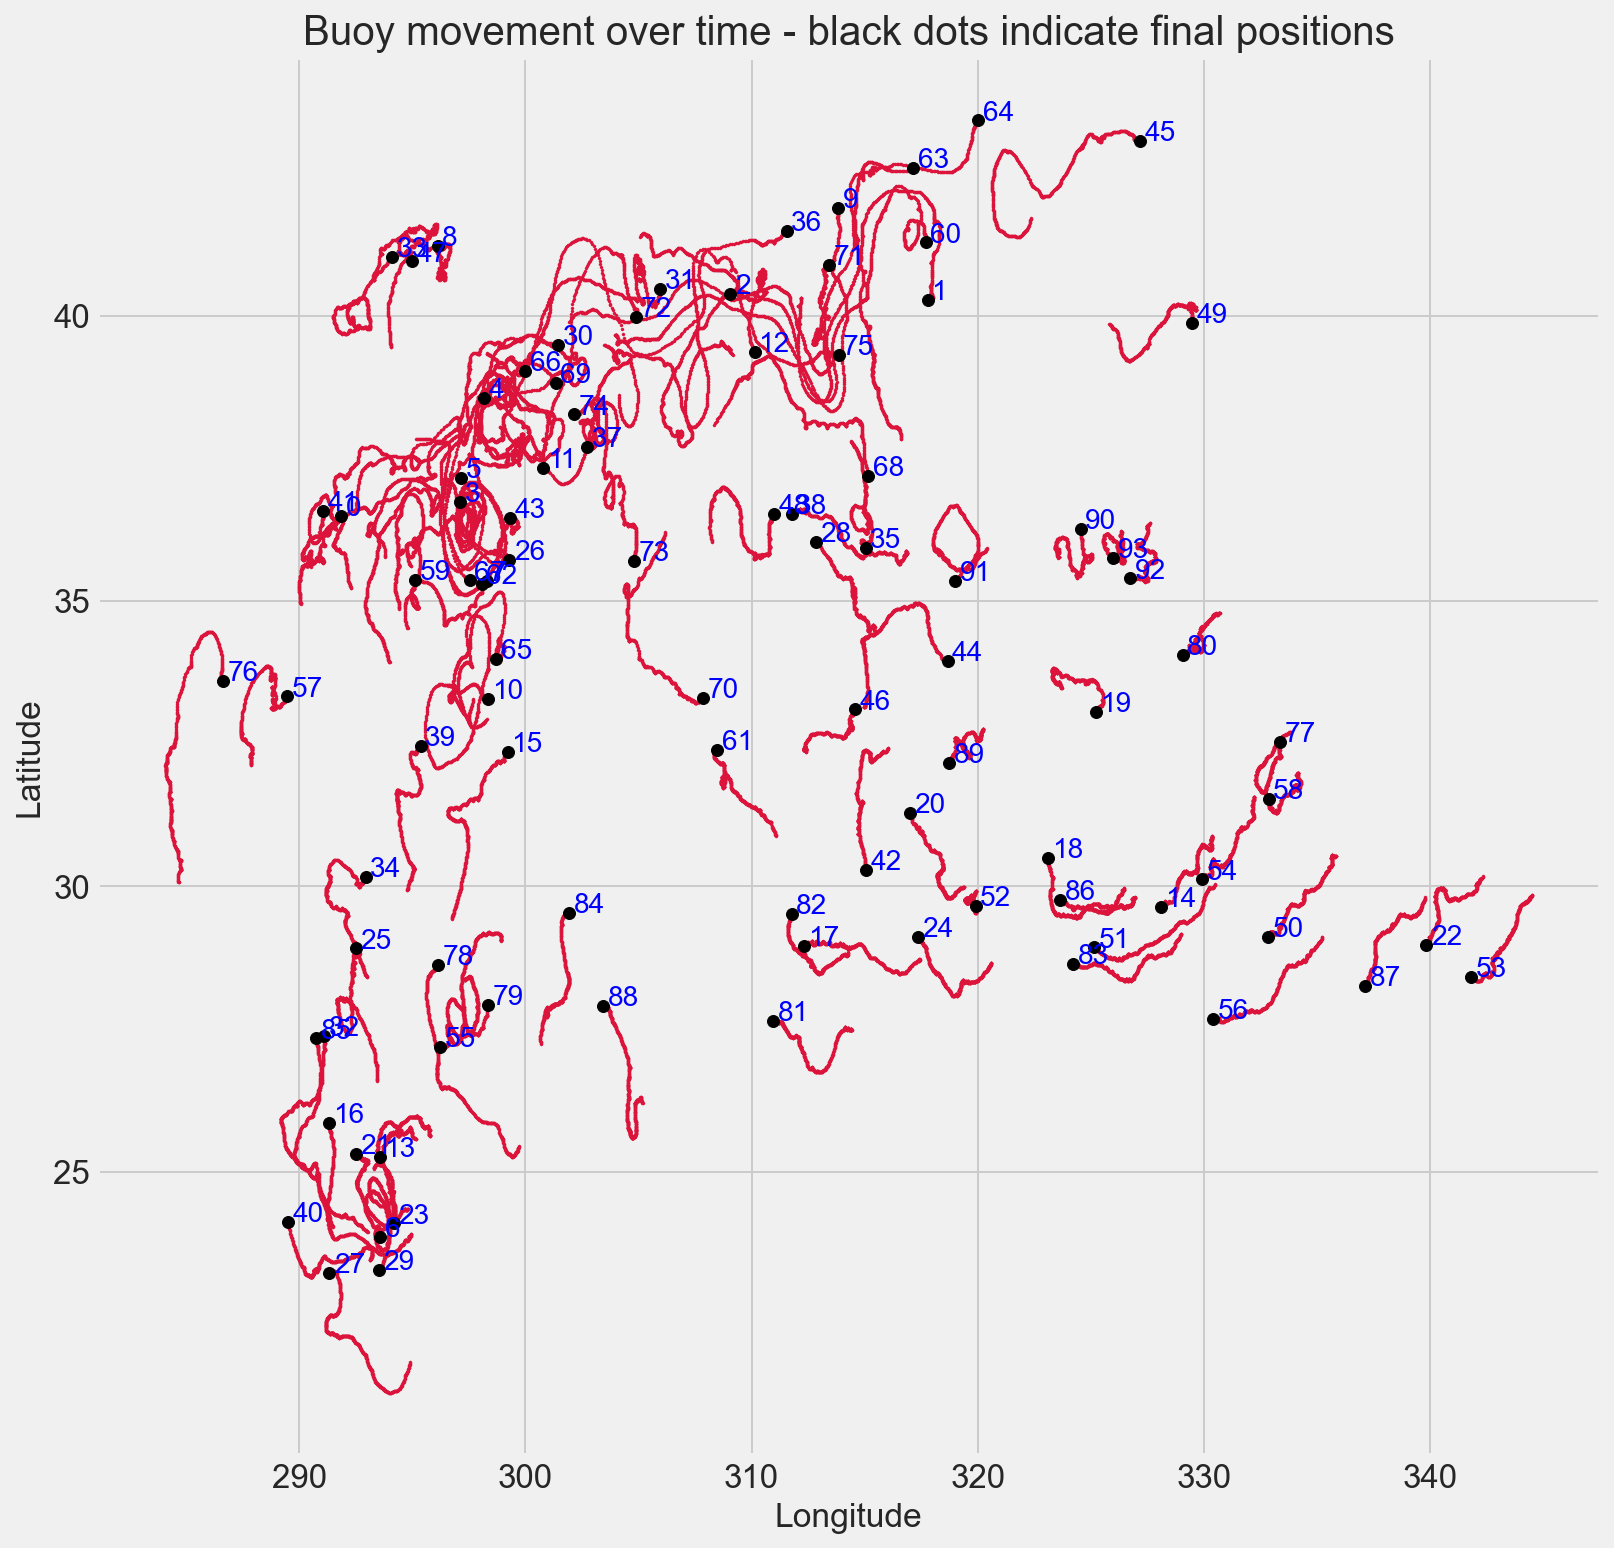

In [16]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data=buoy_data, x='Longitude', y='Latitude', c=['crimson'], edgecolor=None, s=2.5, ax=ax)
for buoy in buoy_data['Spot Id'].unique():
    sns.scatterplot(data=buoy_data[buoy_data['Spot Id'] == buoy][-1:],
                        x='Longitude', y='Latitude', c=['black'], edgecolor=None, ax=ax)
    plt.text(x=buoy_data[buoy_data['Spot Id'] == buoy][-1:]['Longitude']+0.2,
                 y=buoy_data[buoy_data['Spot Id'] == buoy][-1:]['Latitude'], s=str(buoy), color='blue')
ax.set_title('Buoy movement over time - black dots indicate final positions')
plt.show()

In [17]:
def plot_path(t=0):
    fig, ax = plt.subplots(figsize=(12, 12))
    x = buoy_data.iloc[t::552, :]['Longitude']
    y = buoy_data.iloc[t::552, :]['Latitude']
    plt.scatter(x, y)
    plt.xlim(280, 350)
    plt.ylim(20, 45)
    plt.show()

In [18]:
widgets.interact(plot_path, t=widgets.Play(min=0, max=551));

interactive(children=(Play(value=0, description='t', max=551), Output()), _dom_classes=('widget-interact',))

In [19]:
def plot_corr(data, feature_1, feature_2, corr_type):
    if corr_type == 'circ':
        corrs = []
        for buoy in data['Spot Id'].unique():
            corrs.append(circcorrcoef(data[data['Spot Id'] == buoy][feature_2][0: -1].values*u.deg,
                     data[data['Spot Id'] == buoy][feature_1][0: -1].values*u.deg).value)
        fig, ax = plt.subplots(figsize=(15, 6))
        f1 = sns.barplot(y=corrs, x=data['Spot Id'].unique())
        f1.set(xlabel=None)
        f1.set(xticklabels=[])
        ax.set_title(f'Circular correlation between {feature_1} and {feature_2} for each buoy')
        plt.show()
    
    elif corr_type == 'lin':
        corrs = []
        for buoy in data['Spot Id'].unique():
            corrs.append(data[data['Spot Id'] == buoy][[feature_1, feature_2]].corr().iloc[1, 0])
        fig, ax = plt.subplots(figsize=(15, 6))
        f1 = sns.barplot(y=corrs, x=data['Spot Id'].unique())
        f1.set(xlabel=None)
        f1.set(xticklabels=[])
        ax.set_title(f'Correlation between {feature_1} and {feature_2} for each buoy')
        plt.show()

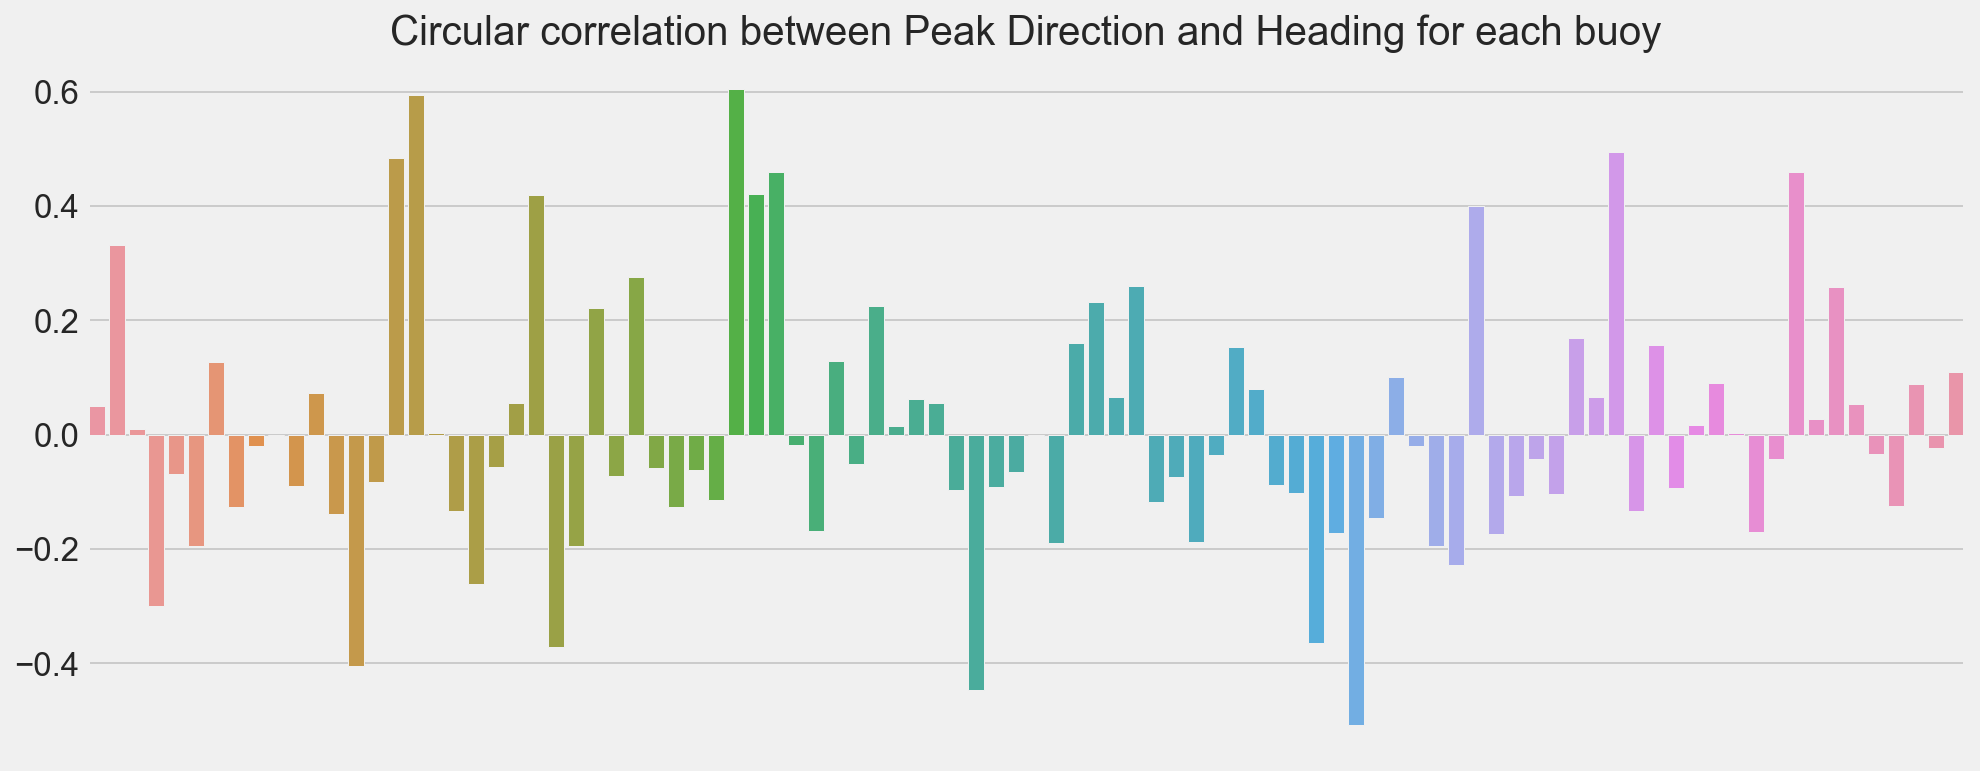

In [20]:
plot_corr(buoy_data, 'Peak Direction', 'Heading', 'circ')

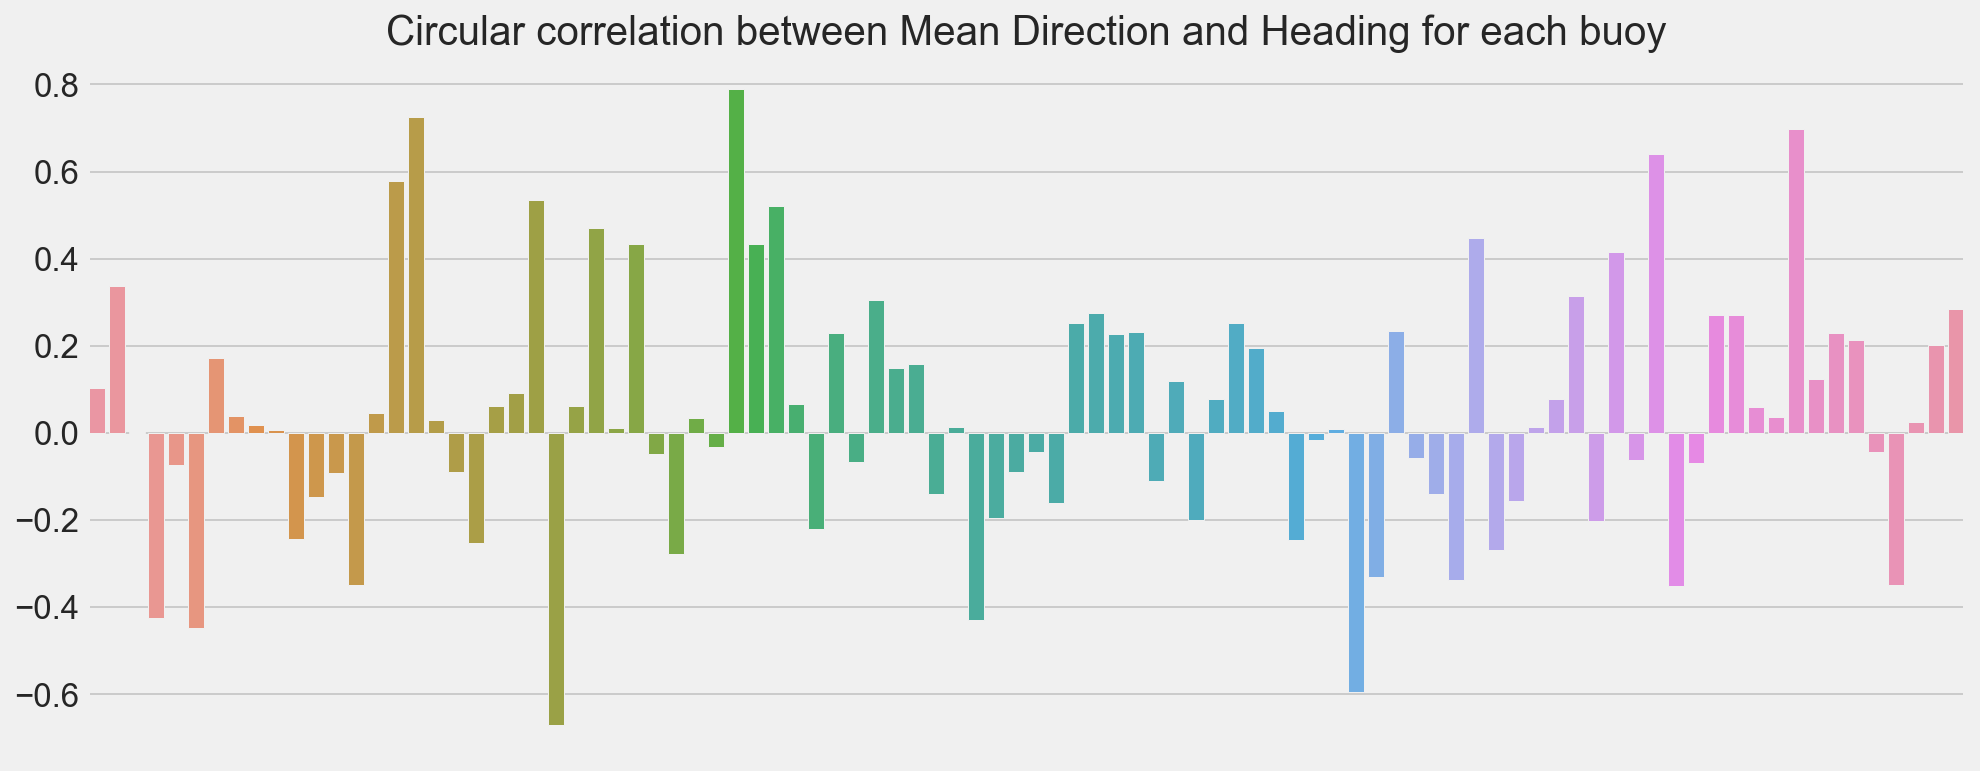

In [21]:
plot_corr(buoy_data, 'Mean Direction', 'Heading', 'circ')

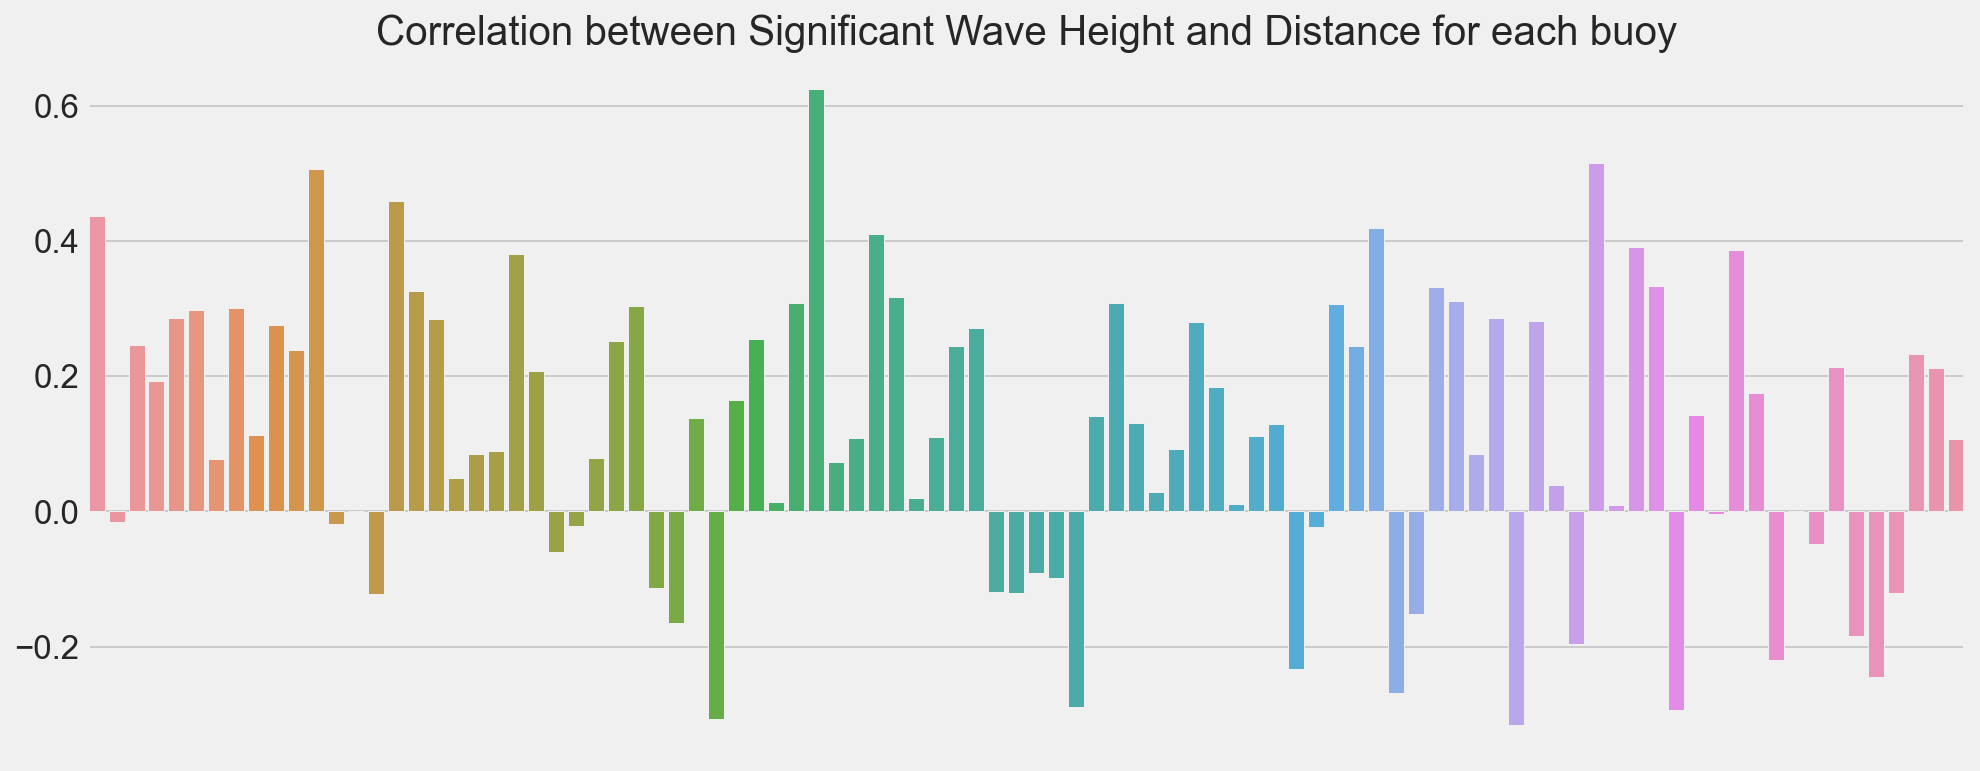

In [22]:
plot_corr(buoy_data, 'Significant Wave Height', 'Distance', 'lin')

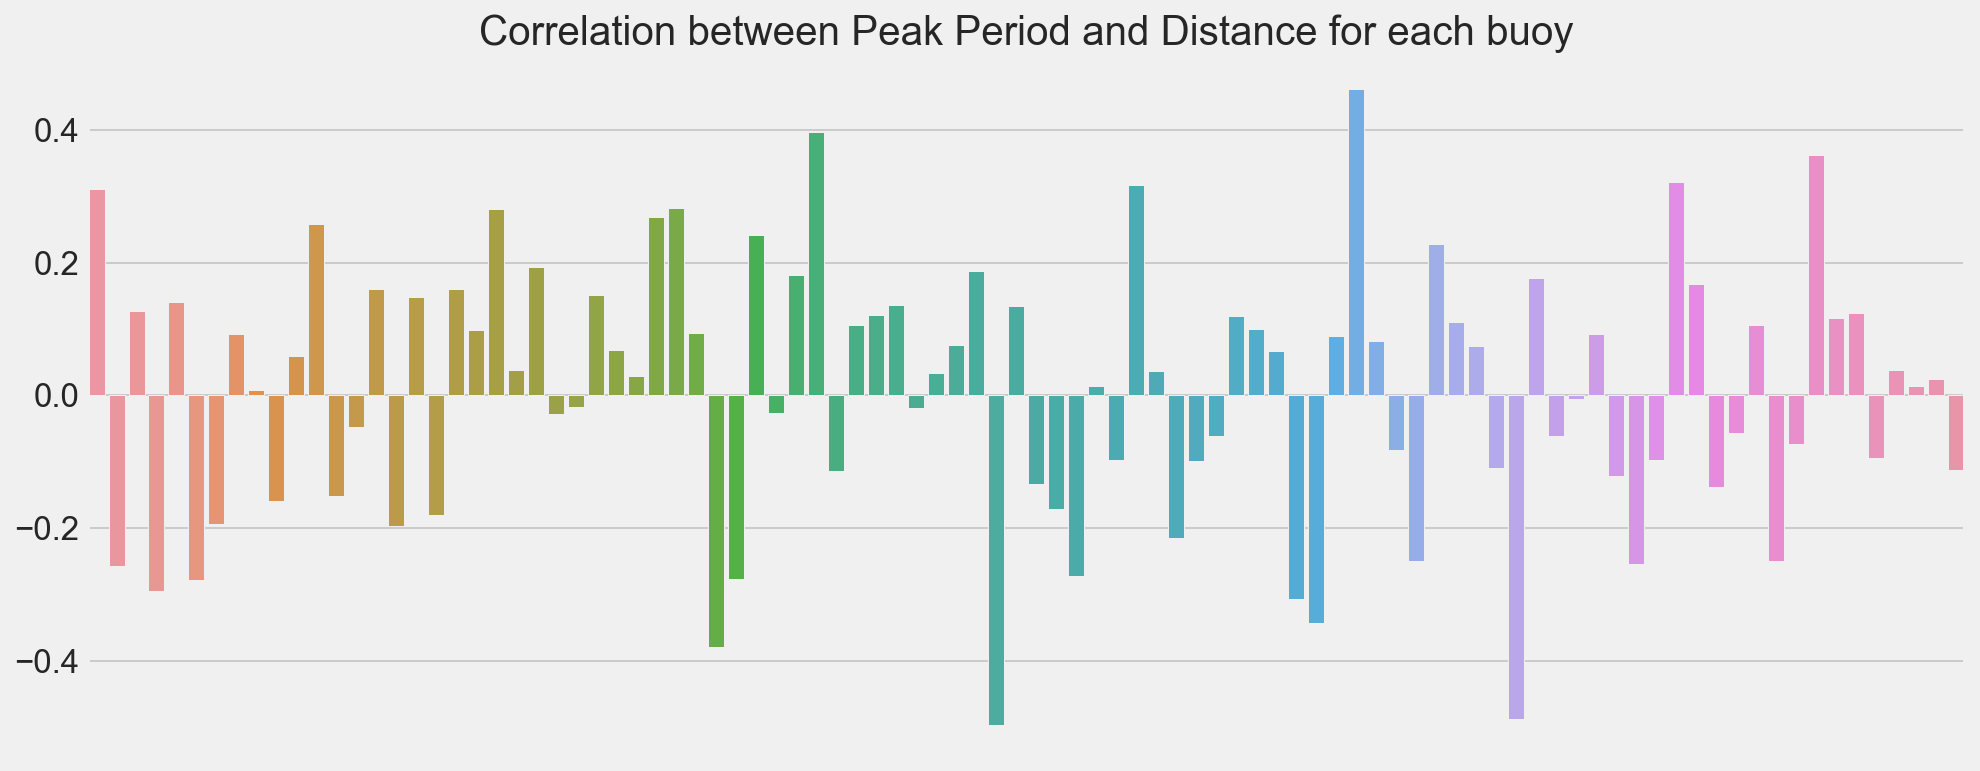

In [23]:
plot_corr(buoy_data, 'Peak Period', 'Distance', 'lin')

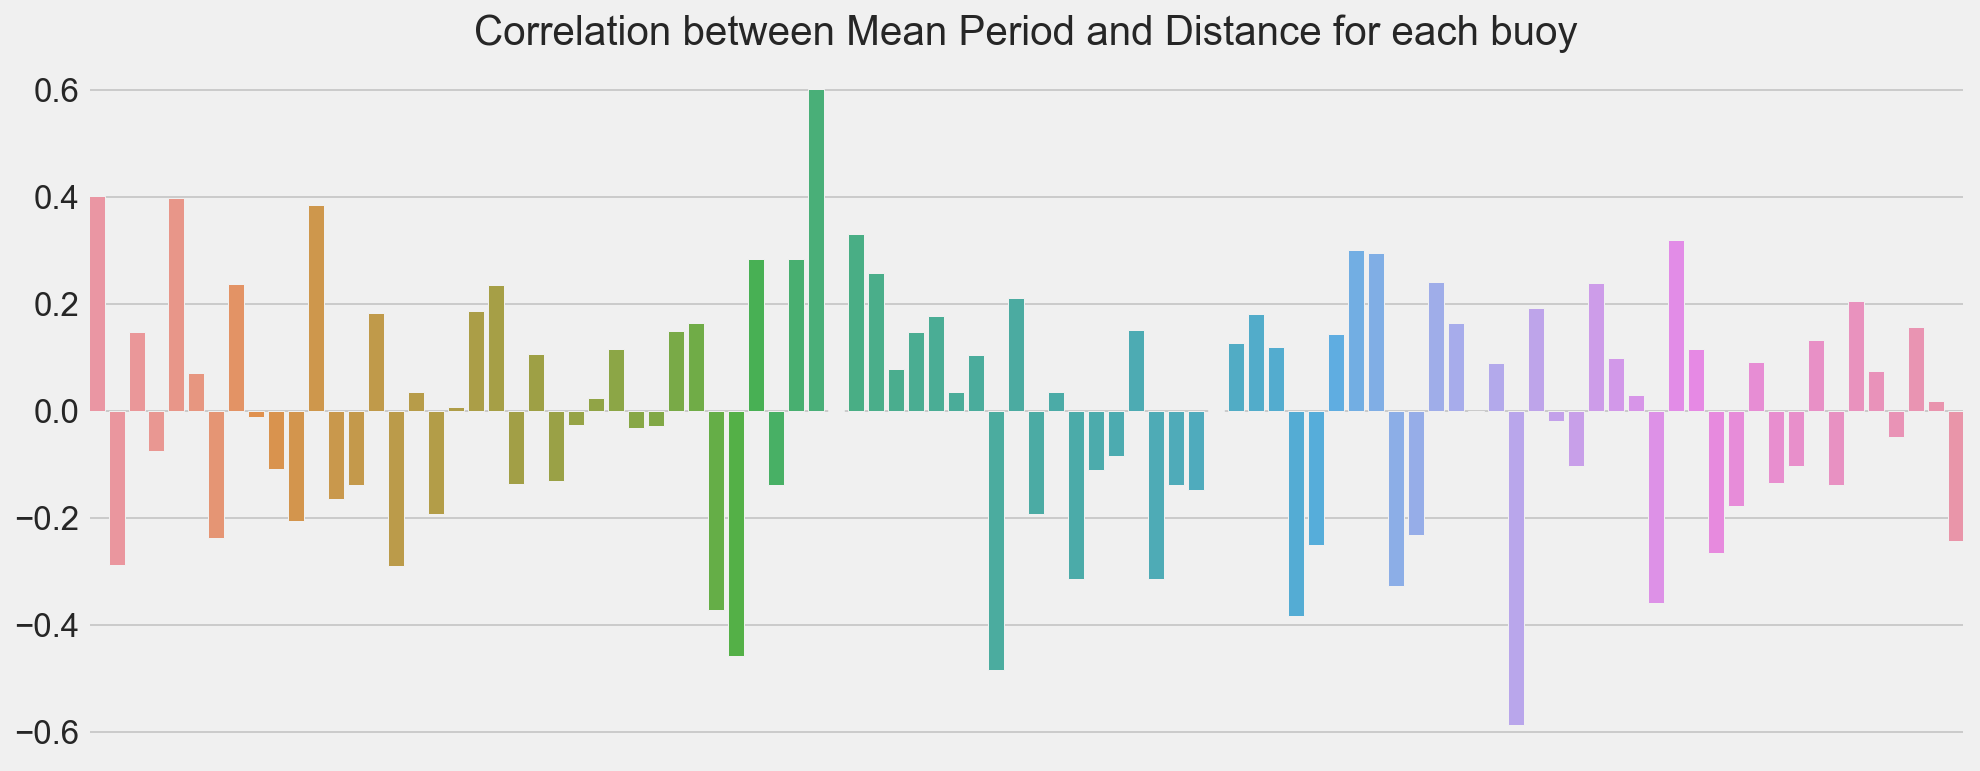

In [24]:
plot_corr(buoy_data, 'Mean Period', 'Distance', 'lin')

In [25]:
def plot_autocorrs(data, buoy_id, feature, lags, alpha=0.05):
    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(data[data['Spot Id'] == buoy_id][feature][1:-2]))
    fig, ax = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
    plot_acf(data[data['Spot Id'] == buoy_id][feature][1:-2], lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[0].set_title(f'{feature} Autocorrelation')
    plot_pacf(data[data['Spot Id'] == buoy_id][feature][1:-2], lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[1].set_title(f'{feature} Partial Autocorrelation')
    plt.show()

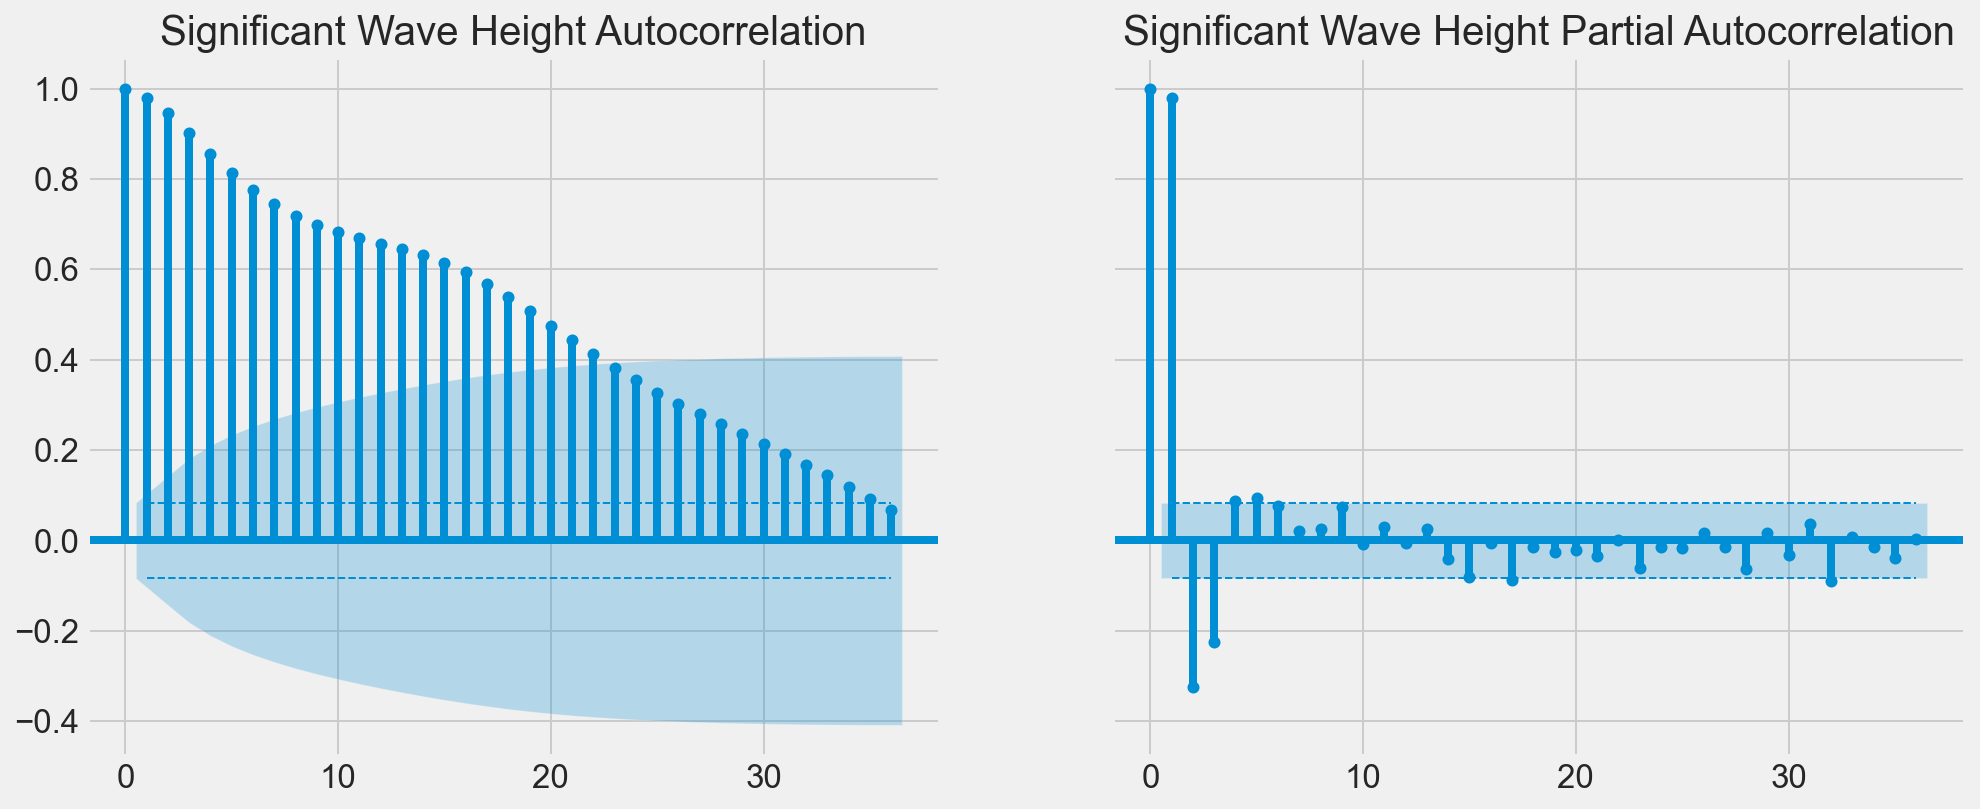

In [26]:
plot_autocorrs(buoy_data, buoy_id=0, feature='Significant Wave Height', lags=36)

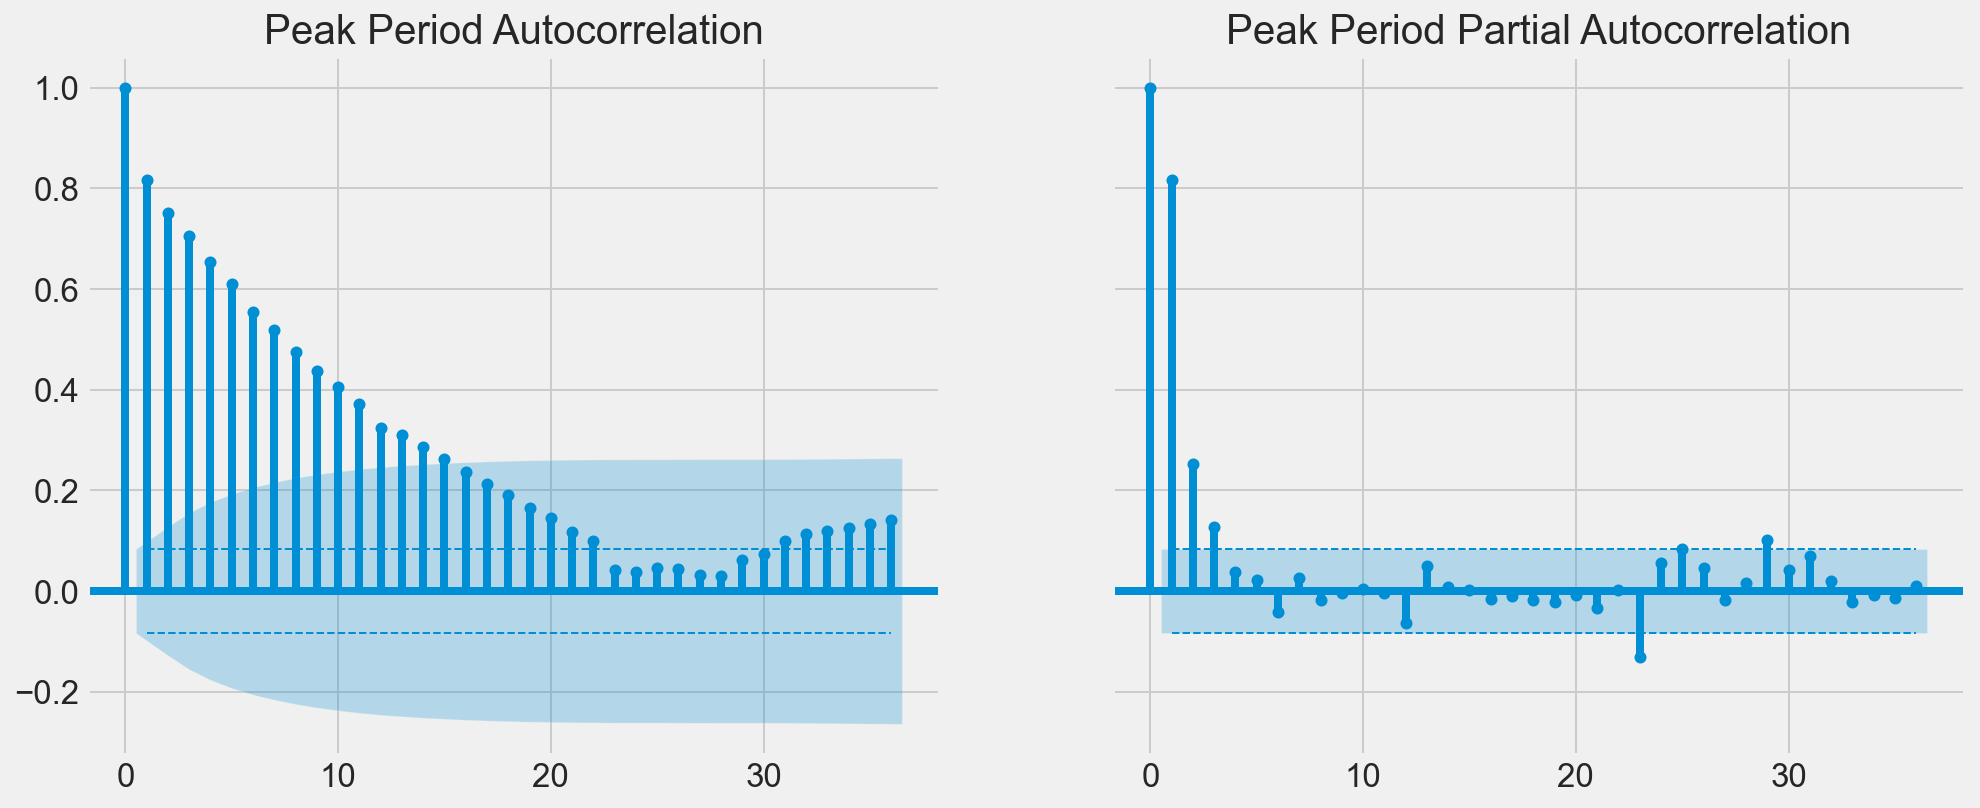

In [27]:
plot_autocorrs(buoy_data, buoy_id=0, feature='Peak Period', lags=36)

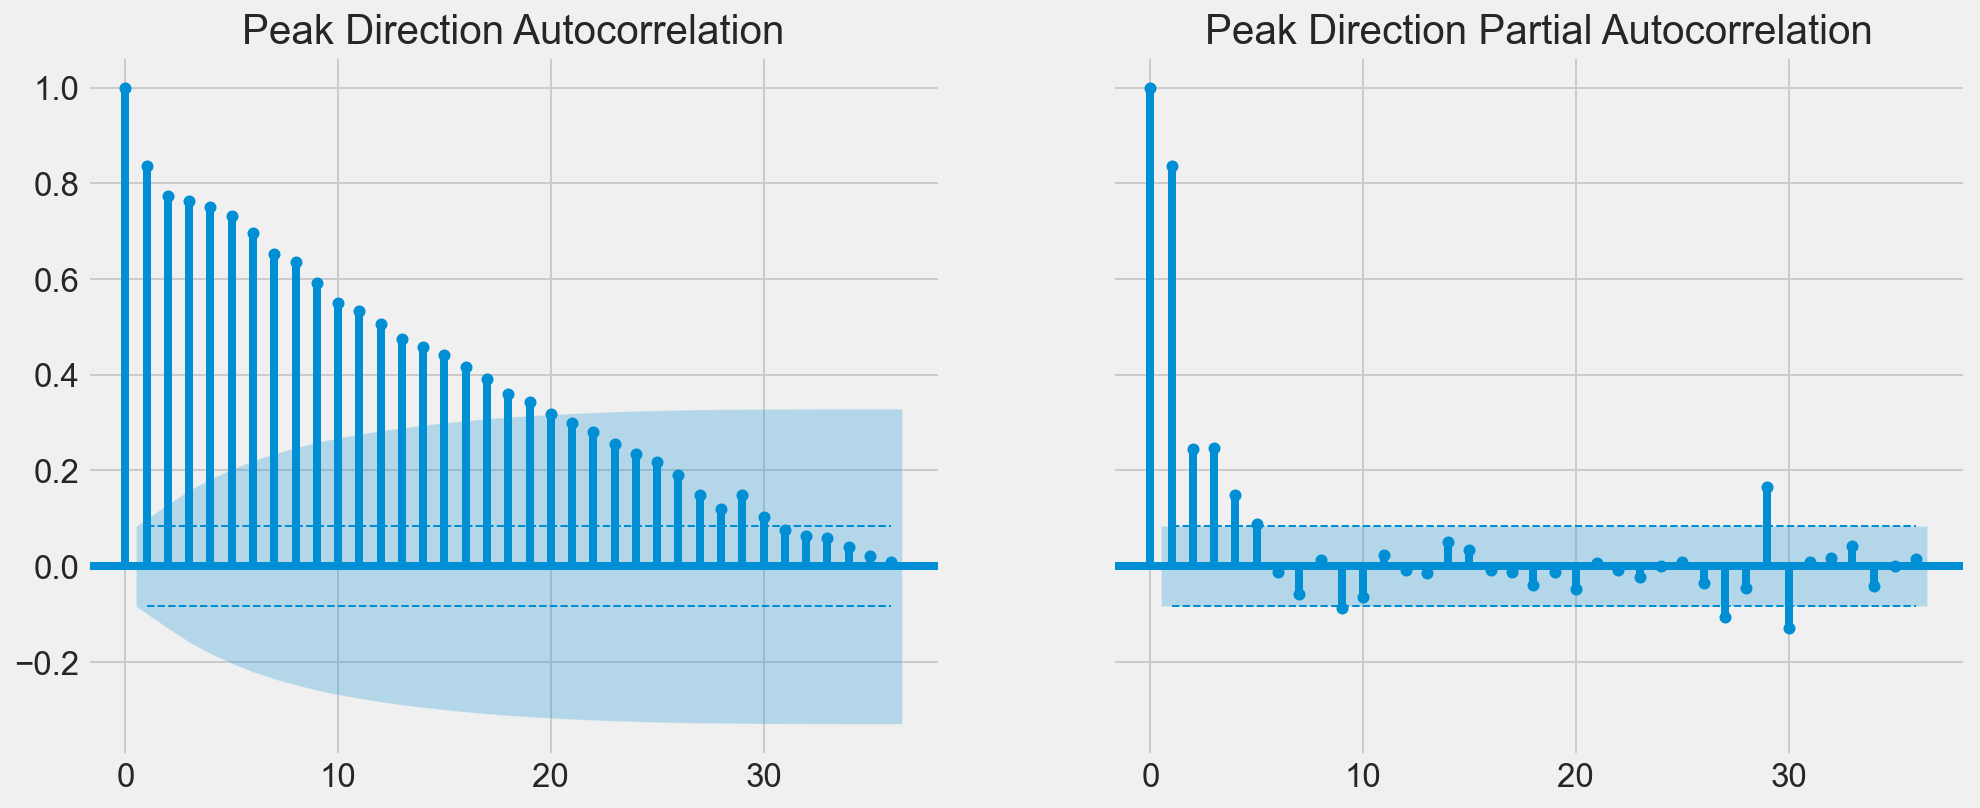

In [28]:
plot_autocorrs(buoy_data, buoy_id=0, feature='Peak Direction', lags=36)

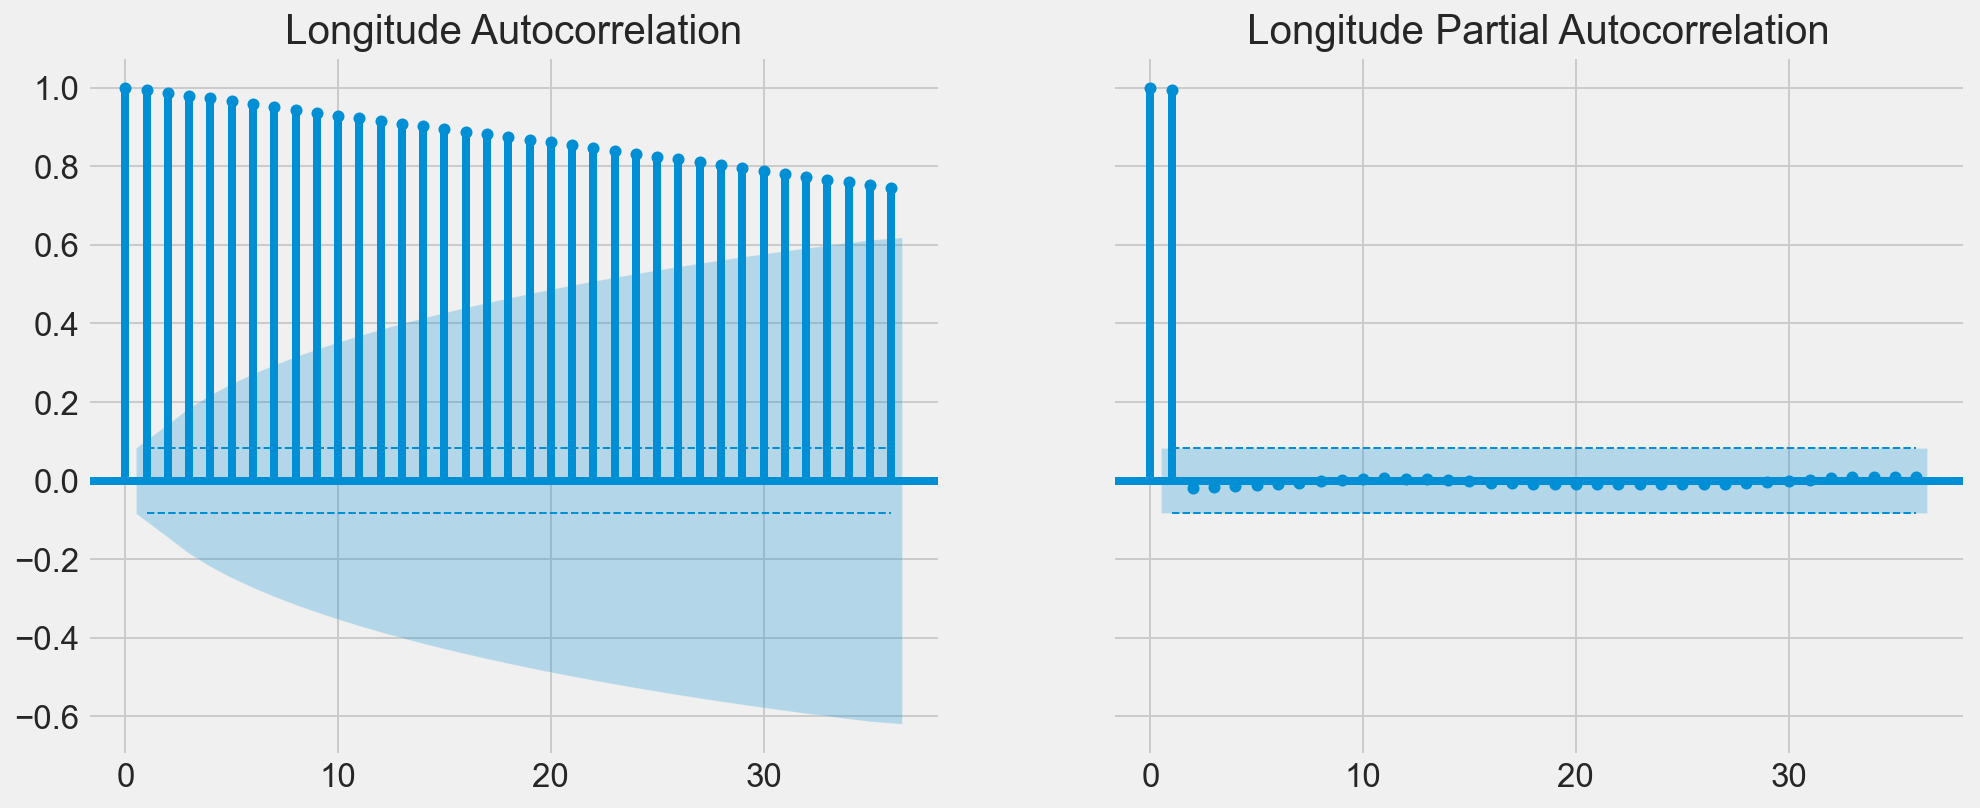

In [29]:
plot_autocorrs(buoy_data, buoy_id=0, feature='Longitude', lags=36)

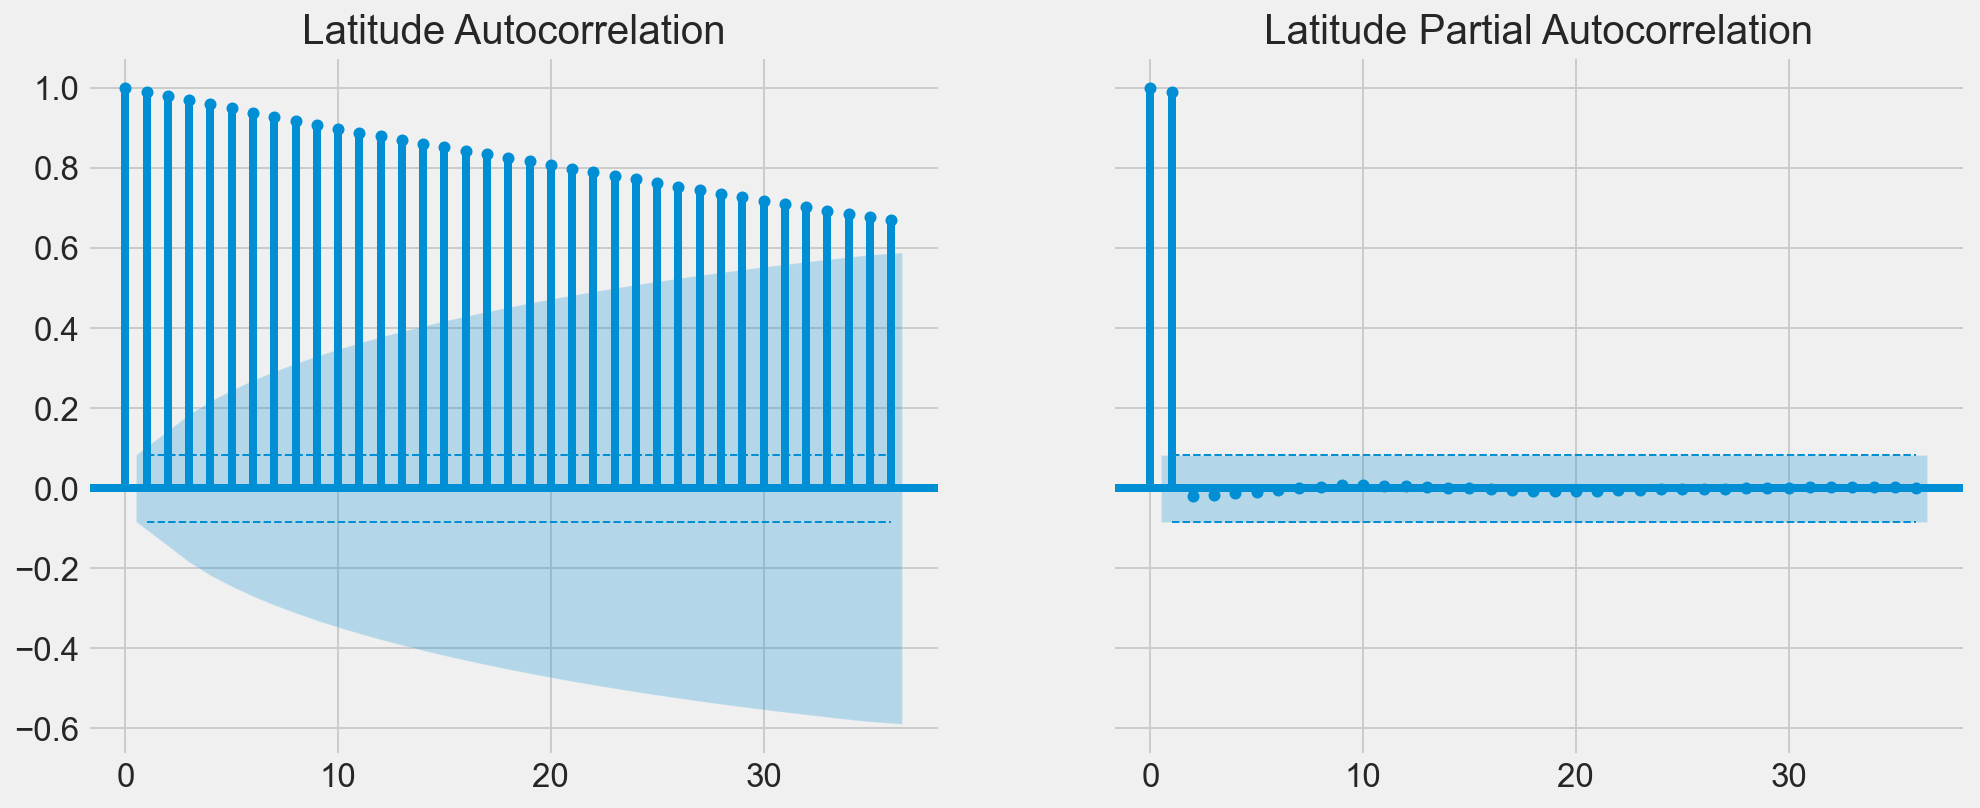

In [30]:
plot_autocorrs(buoy_data, buoy_id=0, feature='Latitude', lags=36)

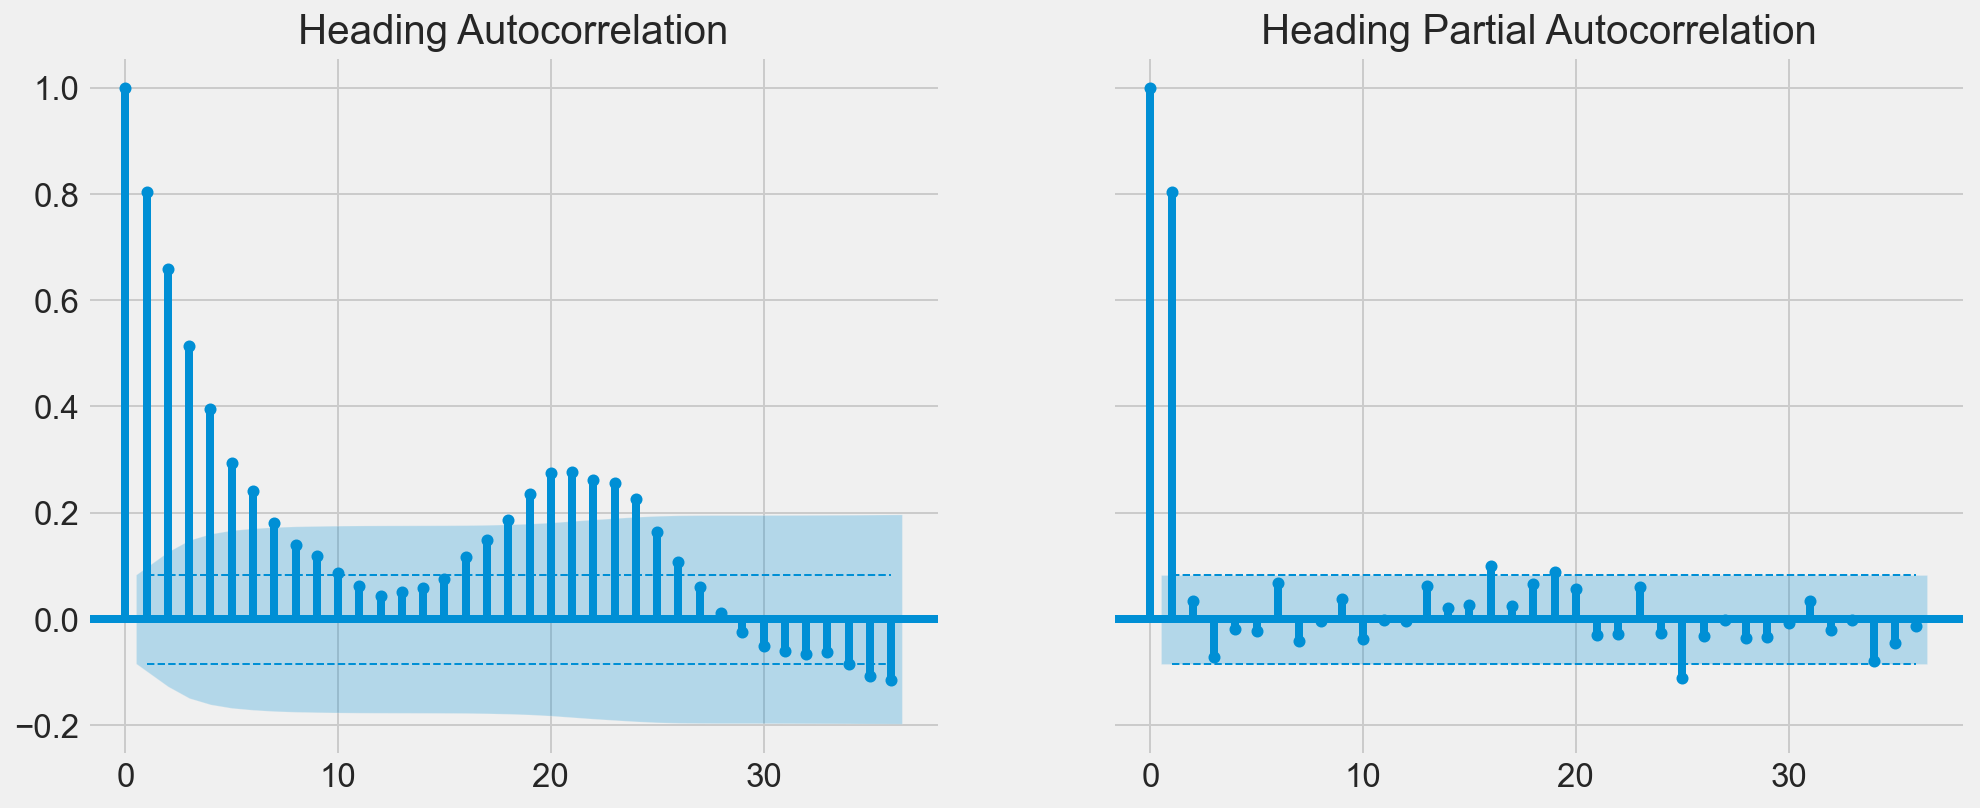

In [31]:
plot_autocorrs(buoy_data, buoy_id=0, feature='Heading', lags=36)